# Analysis of the product range. ABC-analysis of E-commerce shop assortment.

**Description of the project**

As part of the project, it is planned to analyze data on sales of goods from an online store and perform an ABC analysis of the assortment.

**Tasks:**

- Conduct an exploratory analysis of the transaction data of the online store of household goods.
- Analyze the trade assortment. Conduct product categorization.
- Select the main and additional assortment
- Formulate and test statistical hypotheses

**Description of data**

The dataset describes the transactions of an online store of household goods.

Available in data:

 - date — order date;
 - customer_id — customer identifier;
 - order_id — order identifier;
 - product — product name;
 - quantity — quantity of goods in the order;
 - price — item price.

## Exploratory data analysis

### Data preprocessing

#### Importing data and libraries. Checking for gaps and matching data types

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import seaborn as sns
import re
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import stats as st
from collections import Counter
from plotly import graph_objects as go

In [2]:
# import data
df = pd.read_csv('....csv')
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
# check for data types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


No gaps were found in the data. It is necessary to convert the data type of the date column to datetime, and most likely to replace the data type of the column with the price from float to int (if the data contains only integer values).

In [4]:
#check for integers
print((df['price'] % 1  == 0).all())

True


In [5]:
#change data type for date column
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

#change price column data type
df['price'] = df['price'].astype('int')

df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112


#### Check for duplicates

In [6]:
#bring product description to lower case
df['product'] = df['product'].str.lower()

#check data for complete duplicates
print(df.duplicated().sum()) 

0


No obvious duplicates found. Let's check the data for implicit duplicates:
- Order number must be unique for each user
- There should not be orders from one user for the same product at different times

In [7]:
#check if there are orders with more than 1 user
double_orders = df.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id > 1')
print('Number of orders that have more than 1 user:', len(double_orders))

Number of orders that have more than 1 user: 29


In [8]:
#exclude from the data orders that have more than 1 user
double_orders = double_orders.reset_index()
df = df.query('order_id not in @double_orders["order_id"]')
df = df.reset_index(drop=True)

In [9]:
#check if there are orders with the same number on different dates
check_duplicates = df[df.duplicated(subset=['customer_id', 'product', 'order_id'], keep=False)]
check_duplicates = check_duplicates.sort_values(by='product')
check_duplicates

,date,customer_id,order_id,product,quantity,price
3260,2019-04-29 15:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,агератум рассада однолетних цветов в кассете п...,2,210
3210,2019-04-28 17:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,агератум рассада однолетних цветов в кассете п...,2,210
3261,2019-04-29 15:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,алиссум рассада однолетних цветов в кассете по...,2,210
3211,2019-04-28 17:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,алиссум рассада однолетних цветов в кассете по...,2,210
4669,2019-06-06 16:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,алиссум скальный желтый объем 1 л,1,105
...,...,...,...,...,...,...
4701,2019-06-07 08:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,"ясколка войлочная белая объем 0,5 л",1,97
2487,2019-03-28 16:00:00,e58284ef-20d2-42dd-879d-fdd6bd653f3f,14597,"ясколка войлочная белая объем 0,5 л",1,97
2508,2019-03-29 14:00:00,e58284ef-20d2-42dd-879d-fdd6bd653f3f,14597,"ясколка войлочная белая объем 0,5 л",1,97
1972,2019-02-25 09:00:00,075873aa-644c-4a09-9253-204f3156ac7b,70438,"ёрш унитазный с деревянной ручкой , ваир 1712012",20,56


Over two thousand lines. Probably there was some error in order registration. We will leave only orders with the latest date. Perhaps users edited / updated the order, and the system registered this as a purchase. Let's assume that the last date-time of the order is correct.

In [10]:
#select orders with the latest date in a separate dataset to remove it from the list of duplicates
keep_duplicates = check_duplicates[check_duplicates.groupby('order_id')['date'].transform('max') == check_duplicates['date']]

#remove incomplete duplicates
check_duplicates = check_duplicates.drop(keep_duplicates.index, axis=0)
df = df.drop(check_duplicates.index, axis=0)
df = df.reset_index(drop=True)
df

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112
...,...,...,...,...,...,...
4760,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"таз пластмассовый 40,0 л пищевой овальный (иж)...",1,404
4761,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,сумка-тележка 2-х колесная gimi argo синяя,1,1087
4762,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157
4763,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"таз пластмассовый со стиральной доской (иж), 1...",1,397


**Section conclusions:**

As a result of data preprocessing:
- changed the data type in the date column
- changed data type with price to integer value
- removed implicit duplicates (one order for several users and the same order at different times, leaving the last order as correct. There is probably a mistake in fixing orders / creating a new number for a new order).
- no data gaps

As a result, 4765 lines (~ 70%) were left for further analysis from the initial 6737 lines.

### Data analysis

#### Checking data for anomalies

In [11]:
#preliminary check of numerical data for anomalies
df.describe()

,order_id,quantity,price
count,4765.000000,4765.000000,4765.000000
mean,48141.777335,2.815740,517.284995
std,27355.072826,17.757156,949.002483
min,12624.000000,1.000000,9.000000
25%,14770.000000,1.000000,90.000000
50%,68852.000000,1.000000,150.000000
75%,70809.000000,1.000000,488.000000
max,73164.000000,1000.000000,14917.000000


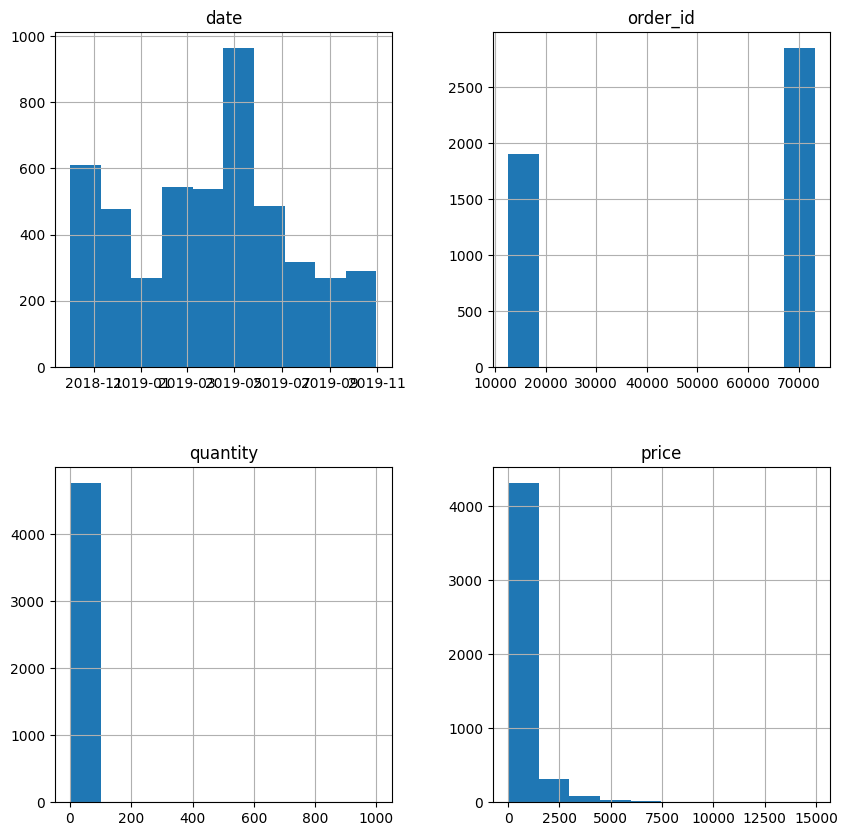

In [12]:
#build histograms by numeric columns in the data
df.hist(figsize=(10,10))
plt.show()

In [13]:
quant_anomaly = np.percentile(df['quantity'], [90, 95, 99])
price_anomaly = np.percentile(df['price'], [90, 95, 99])
print(quant_anomaly)
print(price_anomaly)

[ 3.  7. 30.]
[1424.   2231.   4981.12]


It is necessary to check the number of goods more than 30 and prices above 4900 rubles.

In [14]:
check_quantity = df.query('quantity > @quant_anomaly[2]').sort_values(by='quantity', ascending=False)
check_quantity.head(10)

,date,customer_id,order_id,product,quantity,price
3754,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675
3687,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148
3337,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51
1004,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29
476,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51
241,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19
242,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38
2038,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,плечики пластмассовые размер 52 - 54 тула 1205158,150,20
494,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59
4738,2019-10-28 10:00:00,018fb729-3525-4314-8e4d-1982b1062f9f,73110,"шпингалет 80 мм белый с пружиной, 1102188",100,44


Only the purchase of 1000 plungers looks abnormal. We remove this line from further analysis.

In [15]:
df.drop(df.index[df['quantity'] == 1000], inplace = True)

In [16]:
check_price = df.query('price > @price_anomaly[2]').sort_values(by='price', ascending=False)
check_price.head(10)

,date,customer_id,order_id,product,quantity,price
4121,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917
2264,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737
1669,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437
2509,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077
4675,2019-10-16 15:00:00,d5584388-ffbe-42fd-a746-a98828ec919f,72992,стремянка 7 ступенчатая hailo 8040-707 xxl 13 ...,1,7724
1961,2019-03-14 18:00:00,27d4ce42-352b-4756-bf5b-8724e05d5131,70740,сумка-тележка хозяйственная rolser imx006 bass...,1,7679
4123,2019-07-30 01:00:00,e2fe6b48-1955-4882-925c-733f545df026,72140,сумка-тележка хозяйственная rolser mnb017 fucs...,1,7679
550,2018-11-05 22:00:00,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,сумка-тележка хозяйственная rolser mou041 malv...,1,7597
1069,2018-12-17 17:00:00,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,гладильная доска leifheit airboard compact m p...,1,7424
4284,2019-08-23 12:00:00,8d85f320-5f55-4647-814c-da1a6b21c2a4,72381,урна уличная стальная сальвадор 02.021.0 46х11...,1,7349


No abnormal prices were found in the dataset.

### Primary analysis of prepared data

In [17]:
#Add a column with revenue
df['revenue'] = df['quantity'] * df['price']

In [18]:
print('Start date in data:', df['date'].min())
print('End date in data:', df['date'].max())
print('Number of unique users:', len(df['customer_id'].unique()))
print('Number of orders:', len(df['order_id'].unique()))
print('Number of unique products:', len(df['product'].unique()))
print('Total number of goods sold:', df['quantity'].sum())
print('Total revenue:', df['revenue'].sum())

Start date in data: 2018-10-01 00:00:00
End date in data: 2019-10-31 16:00:00
Number of unique users: 2393
Number of orders: 2754
Number of unique products: 2325
Total number of goods sold: 12417
Total revenue: 3406226


The dataset contains data from October 2018 to November 2019. Let's add columns with the month, time and day of the week to check how orders were distributed over time.

In [19]:
#add a column with date without time
df['date_full'] = df['date'].map(
    lambda x: dt.datetime.strftime(x, '%Y-%m')
)

df['date_full'] = df['date_full'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m')
)

#add a column with time (hour)
df['time'] = df['date'].dt.hour

#add a column with order month
df['month'] = df['date'].dt.month

#add a column with the day of the week
df['weekday'] = df['date'].dt.weekday

df

,date,customer_id,order_id,product,quantity,price,revenue,date_full,time,month,weekday
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,142,2018-10-01,0,10,0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,194,2018-10-01,0,10,0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,112,2018-10-01,0,10,0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,179,2018-10-01,0,10,0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,112,2018-10-01,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...
4760,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"таз пластмассовый 40,0 л пищевой овальный (иж)...",1,404,404,2019-10-01,11,10,3
4761,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,сумка-тележка 2-х колесная gimi argo синяя,1,1087,1087,2019-10-01,12,10,3
4762,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157,157,2019-10-01,13,10,3
4763,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"таз пластмассовый со стиральной доской (иж), 1...",1,397,397,2019-10-01,14,10,3


Let's group the data by month and year to look at the distribution of orders over time.

In [20]:
group_by_date = df.groupby('date_full').agg({'revenue':'sum', 'price':'mean', 'quantity':'sum', 'customer_id':'count', 'product':'count', 'order_id':'nunique'})
group_by_date = group_by_date.reset_index()
group_by_date

,date_full,revenue,price,quantity,customer_id,product,order_id
0,2018-10-01,346921,554.033684,1549,475,475,237
1,2018-11-01,359772,540.193023,1240,430,430,204
2,2018-12-01,341198,835.592715,972,302,302,275
3,2019-01-01,234117,709.663043,631,184,184,167
4,2019-02-01,304157,633.848739,902,357,357,286
5,2019-03-01,249537,489.547912,1046,407,407,243
6,2019-04-01,316122,324.815750,1456,673,673,264
7,2019-05-01,228814,236.545985,1496,685,685,176
8,2019-06-01,233624,413.231481,943,324,324,159
9,2019-07-01,225526,615.808081,541,297,297,197


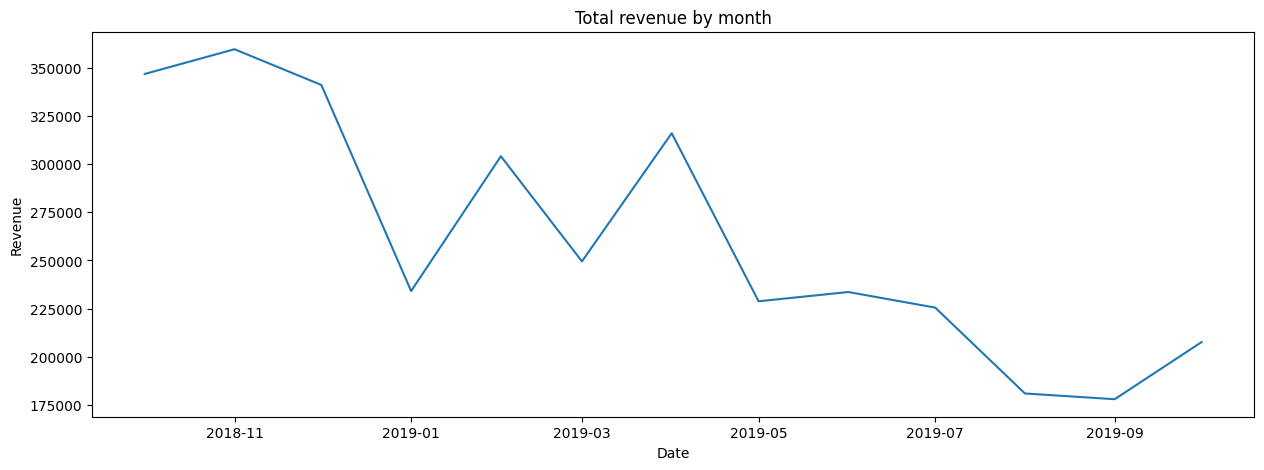

In [21]:
fig = plt.figure()
fig.set_size_inches(15, 5)

plt.plot(group_by_date['date_full'], group_by_date['revenue'])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title('Total revenue by month')
plt.show()

The highest revenue was observed at the very beginning of the available data in October-November 2018. By the end of the period under review, revenues decreased significantly (almost twice). Local peaks were observed in February and April 2019.

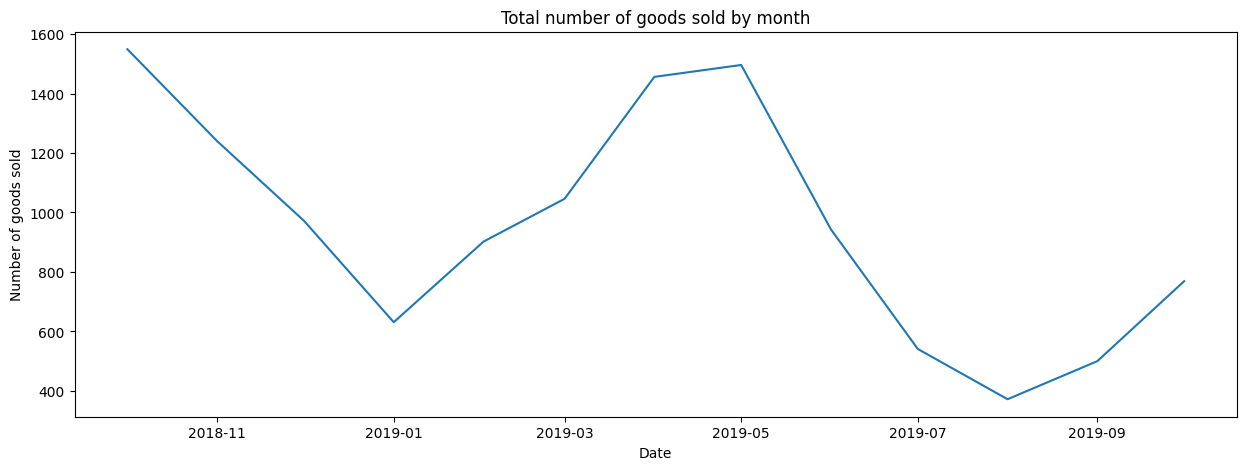

In [22]:
fig = plt.figure()
fig.set_size_inches(15, 5)

plt.plot(group_by_date['date_full'], group_by_date['quantity'])
plt.xlabel("Date")
plt.ylabel("Number of goods sold")
plt.title('Total number of goods sold by month')
plt.show()

The maximum number of goods sold in pieces was observed in October 2018. It is also necessary to note a local peak from March to May in 2019 and a decrease in the number of goods sold by the end of the period under review. Decrease in sales (in pieces) October 2019 to October 2018 by almost 50%.

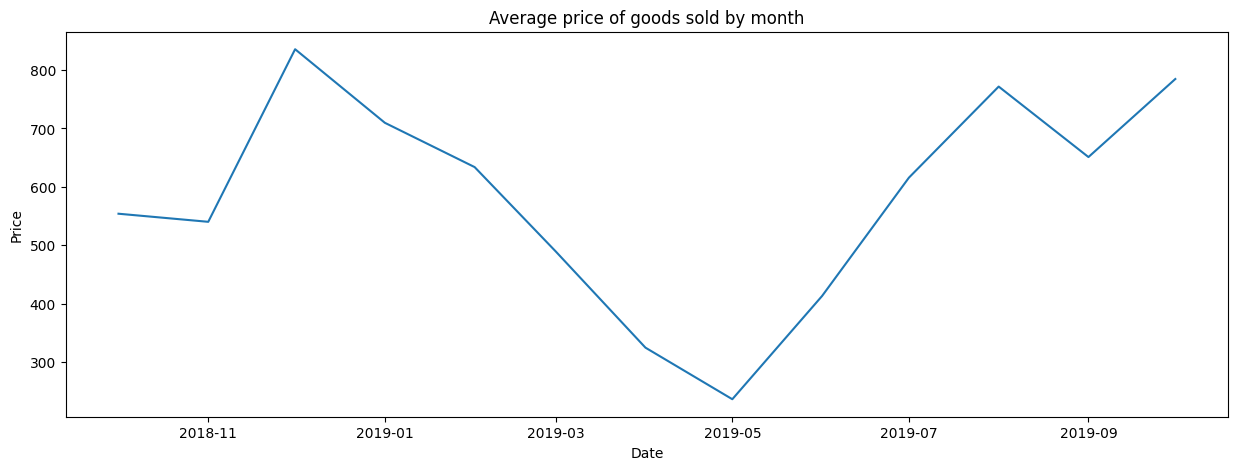

In [23]:
fig = plt.figure()
fig.set_size_inches(15, 5)

plt.plot(group_by_date['date_full'], group_by_date['price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title('Average price of goods sold by month')
plt.show()

The average price of goods sold was decreasing in March-May 2019. Just when there was a peak in sales in pieces. It is likely that goods with a low average price were sold in large quantities.

In [24]:
group_by_month = df.groupby('month').agg({'revenue':'sum', 'price':'mean', 'quantity':'sum', 'customer_id':'count', 'product':'count', 'order_id':'nunique'})
group_by_month = group_by_month.reset_index()
group_by_month

,month,revenue,price,quantity,customer_id,product,order_id
0,1,234117,709.663043,631,184,184,167
1,2,304157,633.848739,902,357,357,286
2,3,249537,489.547912,1046,407,407,243
3,4,316122,324.815750,1456,673,673,264
4,5,228814,236.545985,1496,685,685,176
5,6,233624,413.231481,943,324,324,159
6,7,225526,615.808081,541,297,297,197
7,8,180910,771.665000,372,200,200,173
8,9,177922,651.032407,500,216,216,178
9,10,554527,625.653120,2318,689,689,435


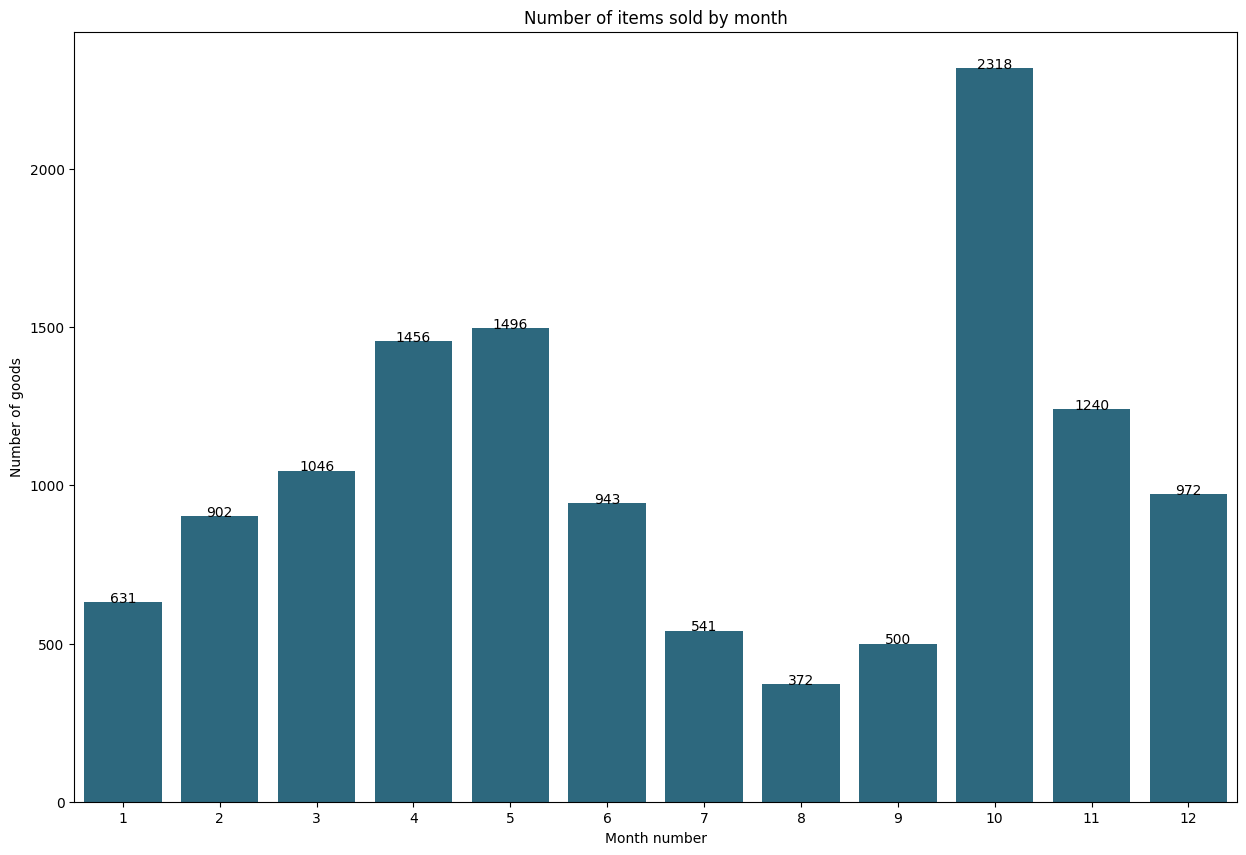

In [25]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(x='month', y='quantity', data=group_by_month, color='#1F6E8C') 
# add labels to columns
for p in ax.patches:
    height = p.get_height() # the height of each column
    # add text
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate
    y = height+0.4, # y-coordinate
    s = '{:.0f}'.format(height), # label
    ha = 'center') # center label

plt.title('Number of items sold by month')
plt.xlabel('Month number')
plt.ylabel('Number of goods')
plt.show()

Grouped data by months, in principle, reflects the picture that we saw before. The largest number of goods sold was in October, May and April. Let's also check whether there is a dependence on the number of sales by hours.

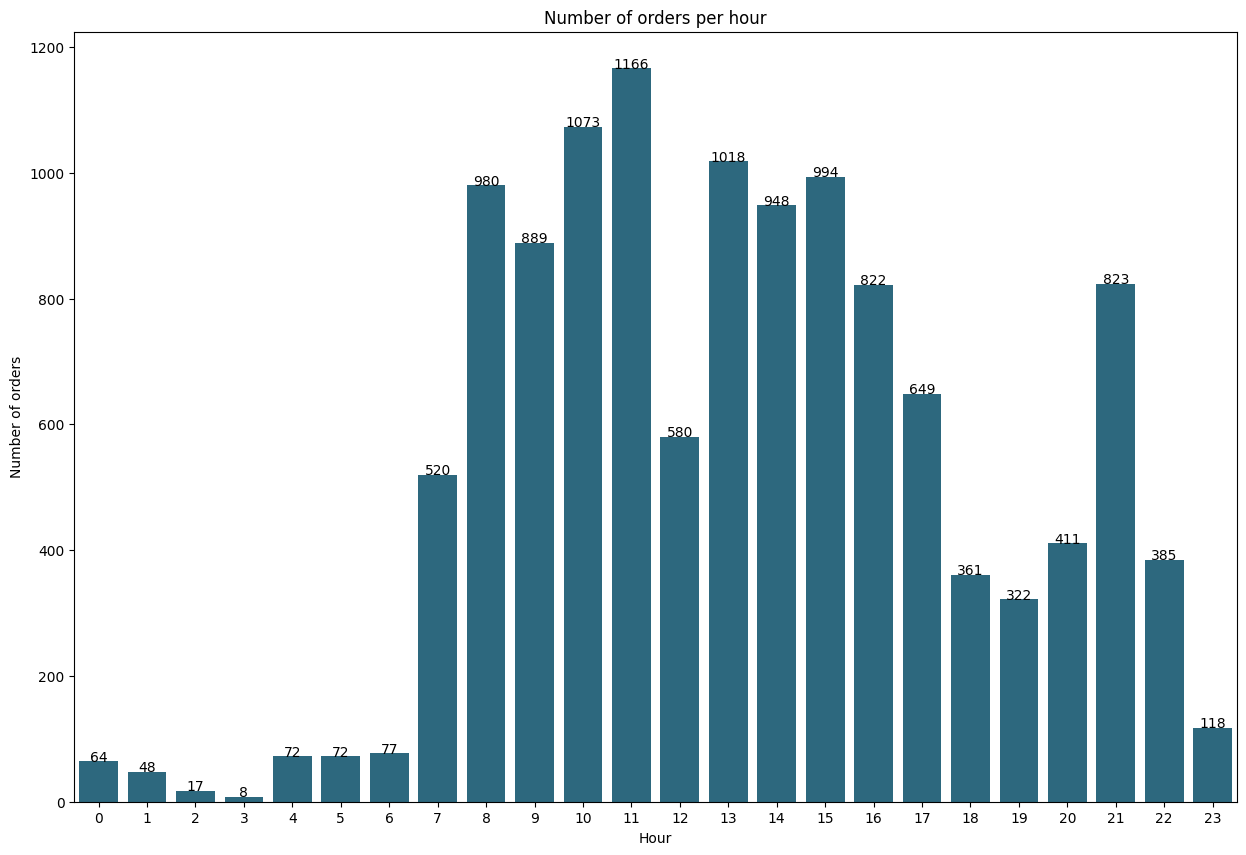

In [26]:
group_by_time = df.groupby('time').agg({'revenue':'sum', 'price':'mean', 'quantity':'sum', 'customer_id':'count', 'product':'count', 'order_id':'nunique'})
group_by_time = group_by_time.reset_index()

plt.figure(figsize=(15, 10))
ax = sns.barplot(x='time', y='quantity', data=group_by_time, color='#1F6E8C') 
# add labels to columns
for p in ax.patches:
    height = p.get_height() # the height of each column
    # add text
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate
    y = height+0.4, # y-coordinate
    s = '{:.0f}'.format(height), # label
    ha = 'center') # center label

plt.title('Number of orders per hour')
plt.xlabel('Hour')
plt.ylabel('Number of orders')
plt.show()

Most of the orders take place from 8 am to 5 pm. Also an obvious surge at 9pm. From 23 to 6, few people order goods in the online store.

**Conclusion by section:**

- As part of the initial analysis, the data was checked for anomalous values ​​and the order for 1000 plungers was deleted.
- We checked how the revenue is distributed over time in the dataset. We found that the decrease in revenue was mainly due to a decrease in the number of goods sold.
- The store sells the most items in October, April and May. In April and May, a large number of goods with a low average price are sold.
- Most of the goods are sold during working hours (from 8 to 17).

## Analysis of the sales assortment

Let's categorize goods by the type of assortment sold. We will divide the goods into categories depending on the names of the goods.

In [27]:
#remove extra characters from names
df = df.apply(lambda x: x.replace({" к ": " ", "ё": "е", "№": "", " и ": " ", " по ": " ", ",": "", " с ": " ", " для ": " ", " на ": " ", " из ": " ", " в ": " ", " со ": " ", "-": ""}, regex=True))

#collect the first two words from the product names
product_simple = df['product'].str.split(expand=True)
product_simple_two = product_simple[0] + ' ' + product_simple[1]
df['product_simple'] = product_simple_two
df

,date,customer_id,order_id,product,quantity,price,revenue,date_full,time,month,weekday,product_simple
0,2018-10-01 00:00:00,ee47d7466d2f4d3c9622c31412542920,68477,комнатное растение горшке алое вера d12 h30,1,142,142,2018-10-01,0,10,0,комнатное растение
1,2018-10-01 00:00:00,ee47d7466d2f4d3c9622c31412542920,68477,комнатное растение горшке кофе арабика d12 h25,1,194,194,2018-10-01,0,10,0,комнатное растение
2,2018-10-01 00:00:00,ee47d7466d2f4d3c9622c31412542920,68477,радермахера d12 см h20 см,1,112,112,2018-10-01,0,10,0,радермахера d12
3,2018-10-01 00:00:00,ee47d7466d2f4d3c9622c31412542920,68477,хризолидокарпус лутесценс d9 см,1,179,179,2018-10-01,0,10,0,хризолидокарпус лутесценс
4,2018-10-01 00:00:00,ee47d7466d2f4d3c9622c31412542920,68477,циперус зумула d12 см h25 см,1,112,112,2018-10-01,0,10,0,циперус зумула
...,...,...,...,...,...,...,...,...,...,...,...,...
4760,2019-10-31 11:00:00,73d1cd355e5f46298cf23fda829d4e58,73156,таз пластмассовый 400 л пищевой овальный (иж) ...,1,404,404,2019-10-01,11,10,3,таз пластмассовый
4761,2019-10-31 12:00:00,1f0a7f3574594f23b4685e45bf481dd1,73158,сумкатележка 2х колесная gimi argo синяя,1,1087,1087,2019-10-01,12,10,3,сумкатележка 2х
4762,2019-10-31 13:00:00,25df96a7c45347089ceaa3dfc7c342ea,73162,герань домашняя (пеларгония зональная) цветуща...,1,157,157,2019-10-01,13,10,3,герань домашняя
4763,2019-10-31 14:00:00,73d1cd355e5f46298cf23fda829d4e58,73164,таз пластмассовый стиральной доской (иж) 1404021,1,397,397,2019-10-01,14,10,3,таз пластмассовый


In [28]:
#for categorization, choose the most common first words from product names
first_word = product_simple[0]
lst = list(first_word)
lst = ' '.join(lst)
lst = lst.split()
lst = dict(Counter(lst))
lst = sorted(lst.items(), key=lambda x:x[1], reverse=True)
d = {k:v for (k,v) in lst if v > 3}
d

{'пеларгония': 702,
 'рассада': 463,
 'сушилка': 267,
 'сумкатележка': 233,
 'муляж': 166,
 'петуния': 139,
 'томата': 131,
 'гладильная': 117,
 'герань': 110,
 'коврик': 104,
 'тележка': 96,
 'чехол': 88,
 'штора': 76,
 'таз': 68,
 'однолетнее': 63,
 'роза': 57,
 'искусственный': 52,
 'калибрахоа': 50,
 'тарелка': 39,
 'набор': 37,
 'бакопа': 37,
 'вешалка': 36,
 'цветок': 35,
 'корзина': 33,
 'скатерть': 31,
 'стремянка': 28,
 'салатник': 22,
 'полки': 21,
 'подвесное': 21,
 'чайник': 19,
 'мята': 19,
 'базилик': 19,
 'фуксия': 19,
 'ерш': 17,
 'банка': 17,
 'щетка': 16,
 'флокс': 16,
 'цикламен': 15,
 'примула': 15,
 'вербена': 15,
 'нож': 14,
 'эвкалипт': 14,
 'контейнер': 14,
 'фиалка': 14,
 'карниз': 14,
 'кружка': 14,
 'дыня': 14,
 'лобелия': 14,
 'сумка': 13,
 'подкладка': 13,
 'швабра': 13,
 'декабрист': 13,
 'комнатное': 12,
 'салфетка': 12,
 'капуста': 12,
 'новогоднее': 12,
 'искусственная': 12,
 'лестницастремянка': 11,
 'подрукавник': 11,
 'ведро': 11,
 'бегония': 11,
 'б

In [29]:
#create a dictionary with categories
categories = {'Household products': {'муляж', 'коврик', 'чехол', 'штора', 'скатерть', 'салфетка', 'ложка',  'ковер', 'сиденье', 'кофр', 'плечики', 'этажерка', 'полотенце', 'зубная', 'терка', 'вешалки', 'комод', 'покрывало', 'хлебница', 'простынь', 'наматрацник', 'вешал', 'одеяло'},
              'Plants': {'пеларгония', 'рассада', 'петуния', 'томат', 'герань', 'однолетнее', 'роза', 'калибрахоа', 'бакоп', 'цветок', 'мята', 'базилик', 'фуксия', 'флокс', 'цикламен', 'примула', 'вербена', 'эвкалипт', 'фиалка', 'дыня', 'лобелия', 'декабрист', 'комнатное', 'капуста', 'бегония', 'бальзамин', 'пуансеттия', 'циперус', 'газания', 'антуриум', 'виола', 'колокольчик', 'арбуз', 'тимьян', 'хлорофитум', 'хризантема', 'космея', 'огурец', 'алиссум', 'эхеверия', 'лаванда', 'мирт', 'гвоздика', 'лавр', 'табак', 'петрушка', 'многолетнее', 'розмарин', 'азалия', 'дендробиум', 'мимоза', 'фаленопсис', 'аптения', 'седум', 'цинния', 'овсянница', 'патиссон', 'мединилла', 'спатифиллум'},
              'Housewares':{'сушилка', 'гладильная', 'таз', 'вешалка', 'корзина', 'банка', 'щетка', 'ерш', 'контейнер', 'подкладка', 'швабра', 'подрукавник', 'ведро', 'перчатки', 'окномойка', 'крючок', 'корыто', 'средство', 'веник', 'ящик', 'коробка', 'измельчитель', 'урна'},
              'Construction and repair':{'тележка', 'инструмент', 'стремянка', 'полки', 'карниз', 'сумка', 'лестница', 'штанга', 'настенная', 'стяжка', 'стремянки', 'стремянки', 'лоток', 'покрытие', 'пружина', 'ручкаскоба', 'шпингалет'},
              'Tableware':{'чайник', 'тарелка', 'салатник',  'нож', 'кружка', 'сковорода', 'кувшин', 'термокружка', 'вилка', 'стакан', 'кастрюля', 'термос', 'tepмокружка'},
}

In [30]:
categories = {v.lower():k for k, lst in categories.items() for v in lst}

df['category'] = (df['product'].str.extract(fr"({'|'.join(categories)})", re.IGNORECASE)
                  [0].str.lower().map(categories))

df['category'] = df['category'].fillna('Other')
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,date_full,time,month,weekday,product_simple,category
0,2018-10-01,ee47d7466d2f4d3c9622c31412542920,68477,комнатное растение горшке алое вера d12 h30,1,142,142,2018-10-01,0,10,0,комнатное растение,Plants
1,2018-10-01,ee47d7466d2f4d3c9622c31412542920,68477,комнатное растение горшке кофе арабика d12 h25,1,194,194,2018-10-01,0,10,0,комнатное растение,Plants
2,2018-10-01,ee47d7466d2f4d3c9622c31412542920,68477,радермахера d12 см h20 см,1,112,112,2018-10-01,0,10,0,радермахера d12,Other
3,2018-10-01,ee47d7466d2f4d3c9622c31412542920,68477,хризолидокарпус лутесценс d9 см,1,179,179,2018-10-01,0,10,0,хризолидокарпус лутесценс,Other
4,2018-10-01,ee47d7466d2f4d3c9622c31412542920,68477,циперус зумула d12 см h25 см,1,112,112,2018-10-01,0,10,0,циперус зумула,Plants


In [31]:
#group data for charts
group_by_category = df.groupby(['date_full', 'category']).agg({'revenue':'sum', 'price':'mean', 'quantity':'sum', 'customer_id':'count', 'product':'count', 'order_id':'nunique'})
group_by_category = group_by_category.reset_index()

categories = df.groupby('category', as_index = False).agg({'revenue':'sum'}).sort_values(by='revenue', ascending=False)

group_by_category

,date_full,category,revenue,price,quantity,customer_id,product,order_id
0,2018-10-01,Construction and repair,76872,1518.108696,267,46,46,44
1,2018-10-01,Household products,69210,403.367925,336,106,106,55
2,2018-10-01,Housewares,128956,797.508333,434,120,120,87
3,2018-10-01,Other,35999,487.709091,278,55,55,38
4,2018-10-01,Plants,24400,162.110236,184,127,127,41
...,...,...,...,...,...,...,...,...
73,2019-10-01,Household products,20989,647.000000,83,24,24,24
74,2019-10-01,Housewares,60785,1047.608696,118,46,46,46
75,2019-10-01,Other,13014,382.043478,146,23,23,23
76,2019-10-01,Plants,19955,174.652778,227,72,72,56


In [32]:
#build a graph with the structure of product categories
fig = go.Figure(data=[go.Pie(labels=categories['category'], values=categories['revenue'], direction ='clockwise', sort=True, title="Revenue structure by product categories")])
fig.show() 

More than 70% of revenue comes from three categories of goods - construction / repair, household goods and goods for the home. Plants, despite their frequent occurrence in the name of goods, occupy only the 4th place in the total revenue.

Let's check the product categories for seasonality and how the revenue was distributed over time.

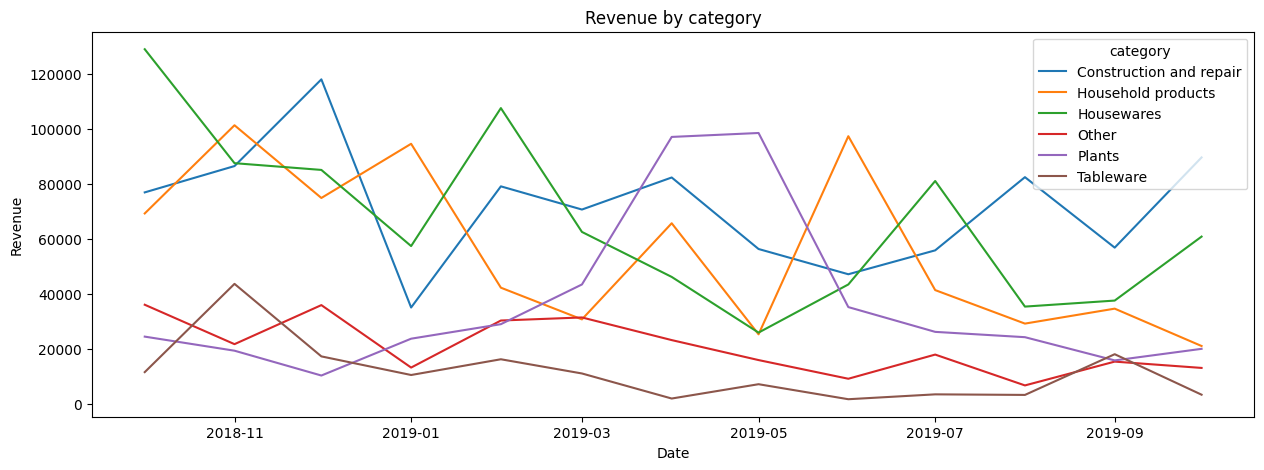

In [33]:
fig = plt.figure()
fig.set_size_inches(15, 5)
ax = sns.lineplot(x=group_by_category['date_full'], y=group_by_category['revenue'], data=group_by_category, hue=group_by_category['category']) 
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title('Revenue by category')
plt.show()

According to the schedule, only the "Plants" category has a pronounced seasonality. Obviously, in the spring during the planting season there is a great demand for seeds and plants.
Significantly reduced revenue household goods and goods for the home. At the same time, the revenue of goods from the repair and construction category did not change much.

In [34]:
chained = df.groupby(['date_full', 'category'], as_index = False).agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
chained = chained.pivot_table(index='date_full', columns='category', values='quantity')
chained = chained.reset_index()
chained['date_full'] = chained['date_full'].map(
    lambda x: dt.datetime.strftime(x, '%Y-%m')
)

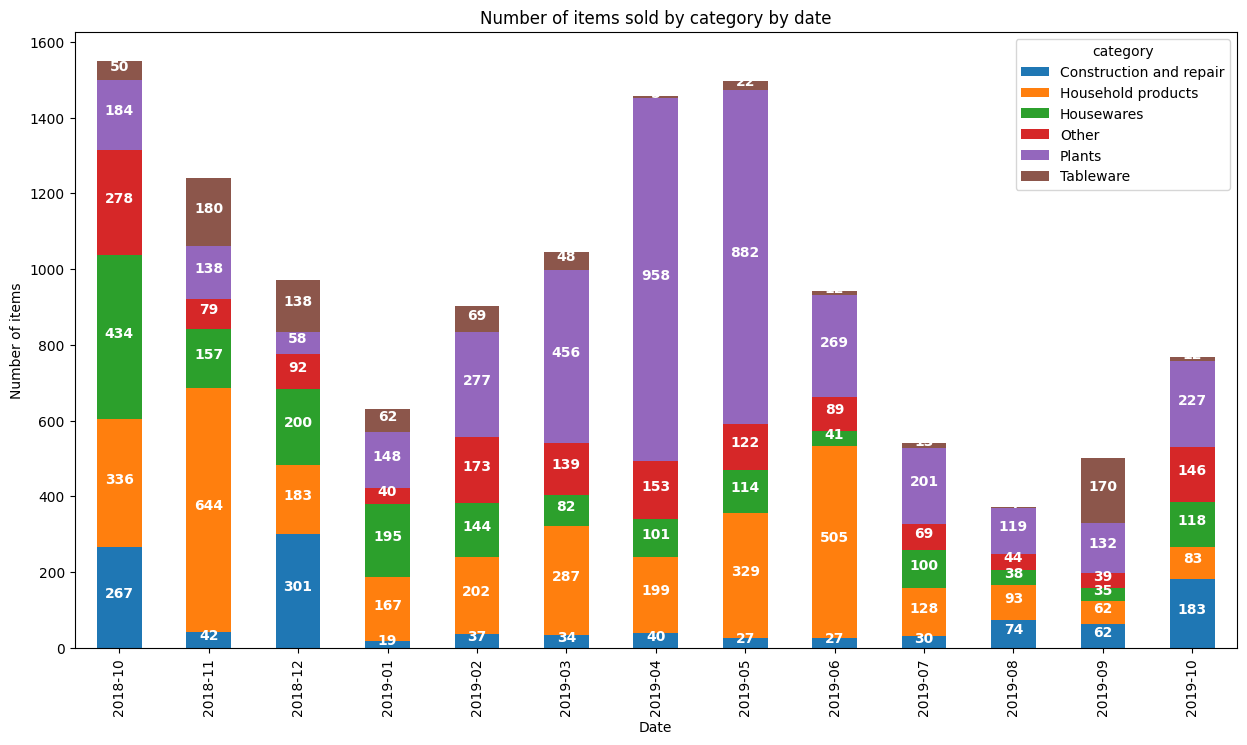

In [35]:
ax = chained.plot(x='date_full', kind='bar', stacked=True,
        title='Number of items sold by category by date', xlabel='Date', ylabel='Number of items',figsize=(15,8))

   
# function to add a caption to each block
for bar in ax.patches:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
     
      bar.get_y() + bar.get_height()/2,

      round(bar.get_height()),
      ha='center',
      color='w',
      weight='bold',
      size=10
  )   
plt.show()

The graph shows that the category "Plants" in the number of orders confidently leads in the spring season. It is also noticeable how the number of goods sold in the segment of household and household goods decreased (from 300-400 in October 2018 to 40-100 in October 2019).

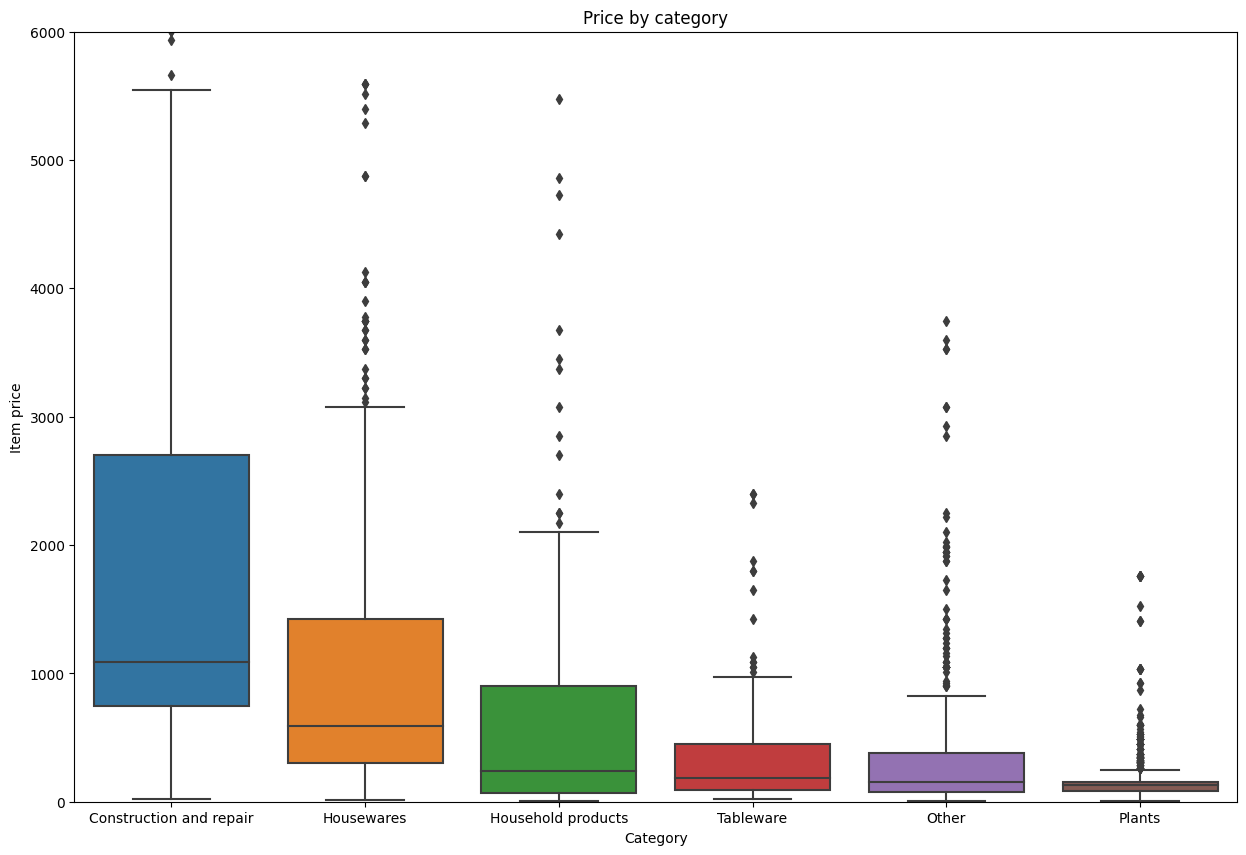

In [36]:
#build a visualization
# prepare additional dataset for sorting medians
grouped = df.loc[:,['category', 'price']] \
    .groupby(['category']) \
    .median() \
    .sort_values(by='price', ascending=False)

#build a chart with sorting
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x=df['category'], y=df['price'], order=grouped.index)
ax.set_ylim([0, 6000])
plt.title('Price by category')
plt.xlabel('Category')
plt.ylabel('Item price')

plt.show()

Categories of goods differ greatly in terms of average price. The most expensive goods on average are construction and repair, and with the cheapest average price are plants.
Key categories of goods in terms of revenue also have the highest average price.

**Section conclusions:**
- More than 70% of revenue comes from three categories of goods - construction / repair, household goods and goods for the home.
- Plants in 4th place incl. revenue, although they lead in terms of the number of orders. This is due to the fact that the category "Plants" has the lowest average price compared to other segments.
- The decrease in revenue in 2019 is due to a decrease in the number of goods sold in the segment of household and household goods (from 300-400 in October 2018 to 40-100 in October 2019).

## ABC analysis. Allocation of the main and additional assortment

To select the main and additional assortment, the ABC method is applied.

First, select products that bring 80% -15% -5% of revenue and assign them categories A-B-C, respectively. Then, within each category, we will define products that bring 80% -15% -5% of the number of sales in pieces and also assign categories. After, we combine the categories and the product range will be divided into 9 segments from AA to CC.

In [37]:
#define the ABC category for products by revenue
total_revenue = df['revenue'].sum()
df['%_of_revenue'] = df['revenue'] / total_revenue * 100
data = df.sort_values(by='revenue', ascending=False)
data = data.reset_index(drop=True)

cumulative_diff = []

for index in range(len(data['%_of_revenue'])):
    if index > 0:
        cumulative_diff.append(cumulative_diff[index-1] - data['%_of_revenue'][index])
    else:
        cumulative_diff.append(100 - data['%_of_revenue'][index])
        
data['cumulative_diff'] = cumulative_diff
data.head()

,date,customer_id,order_id,product,quantity,price,revenue,date_full,time,month,weekday,product_simple,category,%_of_revenue,cumulative_diff
0,2019-06-11 07:00:00,146cd9bfa95c4afb915b5f6684b17444,71668,вешалки мягкие деликатных вещей 3 шт шоколад,334,148,49432,2019-06-01,7,6,1,вешалки мягкие,Household products,1.451225,98.548775
1,2019-01-15 13:00:00,58a4c3cc504f43eaa74abae19e665552,69830,простынь вафельная 200х180 см wellness rw18001...,27,1755,47385,2019-01-01,13,1,1,простынь вафельная,Household products,1.391129,97.157646
2,2018-12-21 16:00:00,6987e6d6a63a4ce2a2d0f424092d235e,69504,тележка багажная delta тбр22 синий грузоподъем...,57,574,32718,2018-12-01,16,12,4,тележка багажная,Construction and repair,0.960535,96.197111
3,2018-11-29 17:00:00,8fba3604ef574b9fb2fe3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457,29248,2018-11-01,17,11,3,набор ножей,Tableware,0.858663,95.338448
4,2018-11-06 12:00:00,1b2764ad91514051a46a9b01b62e6335,68878,"урна уличная ""гео"" hobbyka/хоббика 59*375см сталь",5,4874,24370,2018-11-01,12,11,1,урна уличная,Housewares,0.715455,94.622993


In [38]:
#create a function for categorization (letter assignment)
def categorize_ABC(cumulative_diff):
    try:
        if 0 < cumulative_diff < 5:
            return 'C'
        elif 5 <= cumulative_diff < 20:
            return 'B'
        elif cumulative_diff >= 20:
            return 'A'
    except:
        pass

In [39]:
data['revenue_group'] = data['cumulative_diff'].apply(categorize_ABC)
data.head()

,date,customer_id,order_id,product,quantity,price,revenue,date_full,time,month,weekday,product_simple,category,%_of_revenue,cumulative_diff,revenue_group
0,2019-06-11 07:00:00,146cd9bfa95c4afb915b5f6684b17444,71668,вешалки мягкие деликатных вещей 3 шт шоколад,334,148,49432,2019-06-01,7,6,1,вешалки мягкие,Household products,1.451225,98.548775,A
1,2019-01-15 13:00:00,58a4c3cc504f43eaa74abae19e665552,69830,простынь вафельная 200х180 см wellness rw18001...,27,1755,47385,2019-01-01,13,1,1,простынь вафельная,Household products,1.391129,97.157646,A
2,2018-12-21 16:00:00,6987e6d6a63a4ce2a2d0f424092d235e,69504,тележка багажная delta тбр22 синий грузоподъем...,57,574,32718,2018-12-01,16,12,4,тележка багажная,Construction and repair,0.960535,96.197111,A
3,2018-11-29 17:00:00,8fba3604ef574b9fb2fe3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457,29248,2018-11-01,17,11,3,набор ножей,Tableware,0.858663,95.338448,A
4,2018-11-06 12:00:00,1b2764ad91514051a46a9b01b62e6335,68878,"урна уличная ""гео"" hobbyka/хоббика 59*375см сталь",5,4874,24370,2018-11-01,12,11,1,урна уличная,Housewares,0.715455,94.622993,A


In [40]:
#create a function that will do the categorization inside the already created categories A-B-C
def cat_abc_quant(data, lst):
    
    data_categorized = pd.DataFrame()
          
    for index in range(len(lst)):
        variable = lst[index]
        group = data.query('revenue_group == @variable').sort_values(by='quantity', ascending=False)
        group_total_quantity = group['quantity'].sum()
        group['%_of_quantity'] = group['quantity'] / group_total_quantity * 100

        cumulative_diff_q = []

        for i in range(len(group['%_of_quantity'])):
            if i > 0:
                cumulative_diff_q.append(cumulative_diff_q[i-1] - group['%_of_quantity'].iloc[i])
            else:
                cumulative_diff_q.append(100 - group['%_of_quantity'].iloc[i])

        group['cumulative_diff_q'] = cumulative_diff_q

        group['quantity_group'] = group['cumulative_diff_q'].apply(categorize_ABC)

        group['double_abc'] = group['revenue_group'] + group['quantity_group']
        
        data_categorized = pd.concat([data_categorized,group],ignore_index=True)
        
    return data_categorized

In [41]:
lst = list(data['revenue_group'].unique())
data_categorized = cat_abc_quant(data, lst)

groups_by_revenue = data_categorized.groupby(['revenue_group', 'double_abc'], as_index=False).agg({'revenue':'sum', 'quantity':'sum', 'price':'mean', 'product_simple':'nunique'})

groups_by_revenue['%_of_revenue'] = round(groups_by_revenue['revenue'] / groups_by_revenue['revenue'].sum() * 100, 1)
groups_by_revenue['%_of_quantity'] = round(groups_by_revenue['quantity'] / groups_by_revenue['quantity'].sum() * 100, 1)
groups_by_revenue['%_of_products'] = round(groups_by_revenue['product_simple'] / groups_by_revenue['product_simple'].sum() * 100, 1)

groups_by_revenue

,revenue_group,double_abc,revenue,quantity,price,product_simple,%_of_revenue,%_of_quantity,%_of_products
0,A,AA,685083,5564,205.959799,111,20.1,44.8,8.2
1,A,AB,1347544,1048,1549.655172,199,39.6,8.4,14.7
2,A,AC,692076,348,1988.724138,83,20.3,2.8,6.1
3,B,BA,251103,2710,141.668000,253,7.4,21.8,18.6
4,B,BB,204823,508,403.194882,175,6.0,4.1,12.9
5,B,BC,55067,169,325.840237,88,1.6,1.4,6.5
6,C,CA,122101,1654,82.262044,345,3.6,13.3,25.4
7,C,CB,35902,310,115.812903,94,1.1,2.5,6.9
8,C,CC,12360,103,120.000000,10,0.4,0.8,0.7


The table shows that category A generates 80% of revenue and approximately 55% of all sales, while the group makes up only 29% of all products.
In terms of optimization, the store should consider abandoning the BC, CC, CB groups - the loss in revenue will be about 3%, while such optimization will free up about 13% of the current product range. Additionally, you can consider abandoning the CA group - it has a very low average price, takes a large number of orders (13%), takes more than a quarter of all goods and brings only 4% of revenue.

In [42]:
#draw a graph with the distribution of revenue by category
fig=px.treemap(groups_by_revenue,path=['revenue_group','double_abc'],values='revenue')

print('The volume of revenue from the product range by groups')
fig.show()

The volume of revenue from the product range by groups


Interestingly, the AC and AA groups are practically the same in terms of revenue, and these groups together generate as much revenue as the largest AB group.

In [43]:
#draw a graph with the distribution of the number of goods sold by category
fig=px.treemap(groups_by_revenue,path=['revenue_group','double_abc'],values='%_of_quantity')
print('Sales volume of the product range by groups')
fig.show()

Sales volume of the product range by groups


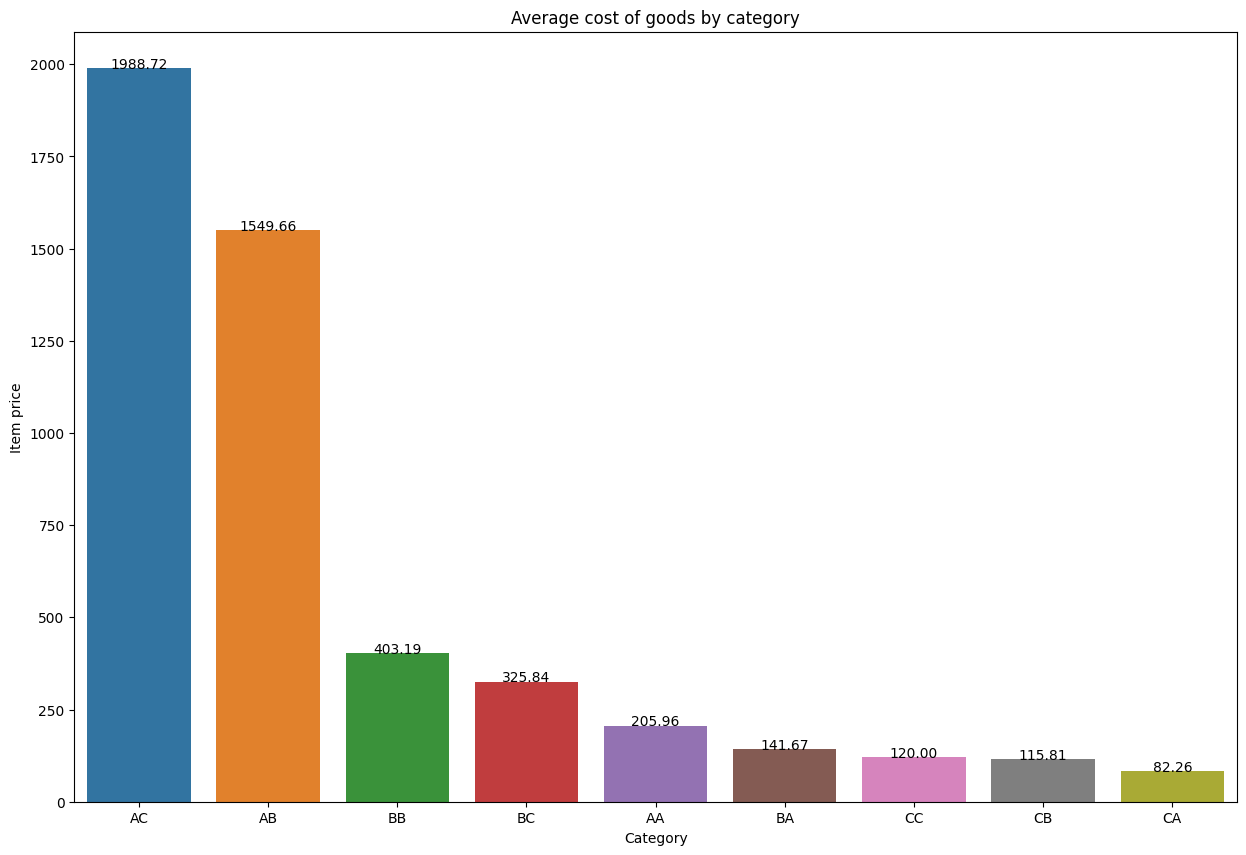

In [44]:
#display the distribution of the average price by category
price = data_categorized.groupby('double_abc')['price'].agg(price='mean').sort_values('price', ascending=False)
price = price.reset_index()

plt.figure(figsize=(15, 10))
ax = sns.barplot(x='double_abc', y='price', data=price) 
# add labels to columns
for p in ax.patches:
    height = p.get_height() 
    ax.text(x = p.get_x()+(p.get_width()/2), 
    y = height+0.01, 
    s = '{:.2f}'.format(height), 
    ha = 'center') 

plt.title('Average cost of goods by category')
plt.xlabel('Category')
plt.ylabel('Item price')
plt.show()

Groups AC and AB stand out strongly with a high average cost of goods. The lowest average price in the CA group.

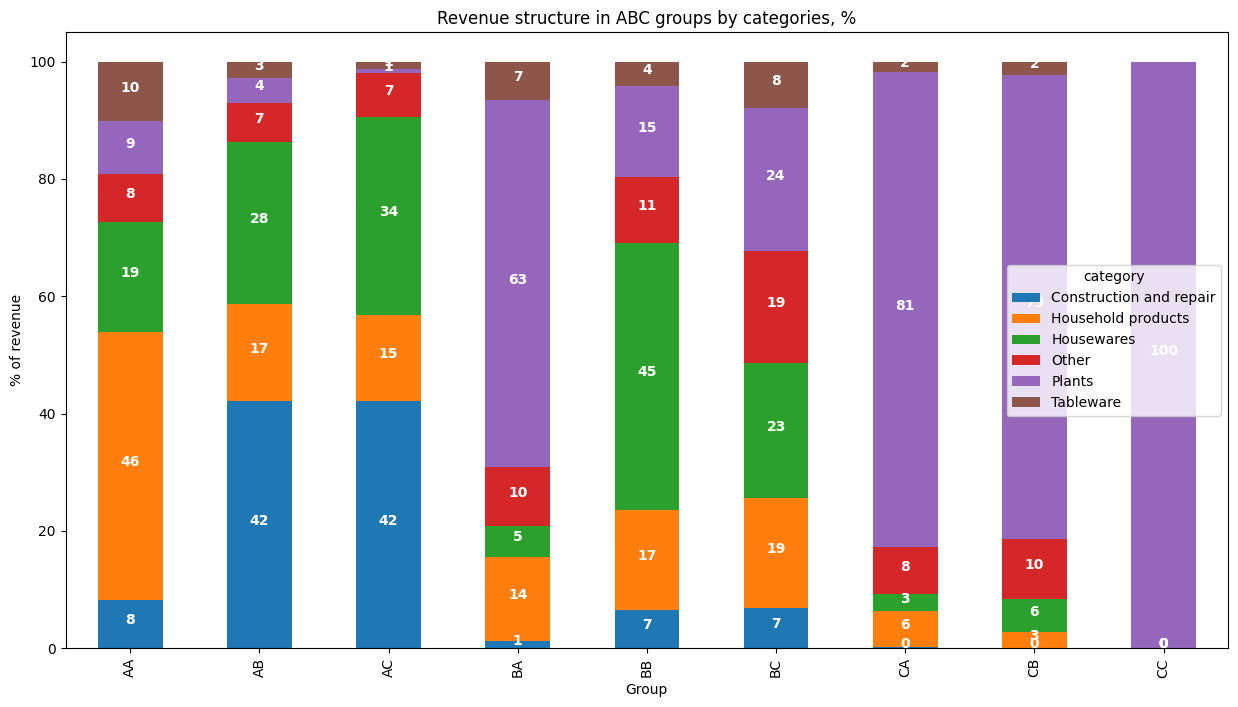

In [45]:
abc = data_categorized.groupby(['category', 'double_abc']).agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False)
abc = abc.pivot_table(index='double_abc', columns='category', values='revenue')
abc = abc.div(abc.sum(axis=1), axis=0) * 100
abc = abc.reset_index()

ax = abc.plot(x='double_abc', kind='bar', stacked=True,
        title='Revenue structure in ABC groups by categories, %', xlabel='Group', ylabel='% of revenue',figsize=(15,8))

# add labels
for bar in ax.patches:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
     
      bar.get_y() + bar.get_height()/2,

      round(bar.get_height()),
      ha='center',
      color='w',
      weight='bold',
      size=10
  )   
plt.show()

And here is the explanation for the low average cost in the CC group - it is made up entirely of plants. Interestingly, the BA group, which generates a large amount of revenue, is 63% made up of plants - probably the most traded goods with a high price.

**Section conclusions:**

Within the framework of the section, we conducted an ABC analysis (first by revenue, and then within the categories by revenue also by the number of goods sold) and received 9 categories. By analyzing these categories, it is possible to divide the range into main and additional.
Obviously, group A as a whole, segments BA and BB are now the main assortment of the store.
Group C as a whole and segment BC are an additional assortment of the store.


In terms of optimization, the store should consider abandoning the BC, CC, CB groups - the loss in revenue will be about 3%, while such optimization will free up about 13% of the current product range. Additionally, you can consider abandoning the CA group - it has a very low average price, takes a large number of orders (13%), takes 25% of all goods and brings only 4% of revenue.

Thus, the company can get rid of 38% of the range, 18% of orders and lose only 7% of revenue. This will allow to focus on sales of the main range.

## Testing statistical hypotheses

**Statistical hypothesis №1.**

Let's check that seasonality is statistically significant in the sales of the plant group.
To do this, we apply the Shapiro-Wilk test on the normal distribution to the number of sales. With pronounced seasonality, the distribution of sales will not be normal.
Accordingly, the null hypothesis is that sales in the "Plants" category are normally distributed.
The alternative hypothesis is that sales in the "Plants" category are not normally distributed.

In [47]:
sample_plants = df[df['category'] == "Plants"]

sample_plants = sample_plants.groupby('date', as_index=False).agg({'quantity': 'sum'})
sample_plants = sample_plants['quantity']

alpha = 0.05  # critical level of statistical significance

results = st.shapiro(sample_plants)
p_value = results[1]  # second value in result array (with index 1) is p-value

print('p-value: ', p_value)

if p_value < alpha:
    print('We reject the null hypothesis: the distribution is not normal')
else:
    print('It was not possible to reject the null hypothesis, the distribution is normal') 

p-value:  5.509232220997491e-36
We reject the null hypothesis: the distribution is not normal


**Conclusion:** The test proved that the seasonality of the sales of the "Plants" group is statistically significant.

**Statistical hypothesis №2.**

Groups AA and AC look very similar in terms of revenue.
Let's check whether there is a statically significant difference in revenue in the AC group from the AA groups, for this we apply the Mann-Whitney test.


Null hypothesis: there are no statistically significant differences in revenue between groups. Alternative: there are differences in the average between groups.

In [48]:
sample_AC = data_categorized[data_categorized['double_abc'] == "AA"]['revenue']

sample_AA = data_categorized[data_categorized['double_abc'] == "AC"]['revenue'] 

alpha = 0.05  # critical level of statistical significance

results = st.mannwhitneyu(sample_AC, sample_AA)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print(
        'Null hypothesis failed to be rejected, no difference can be inferred'
    ) 

p-value:  0.18574961821485125
Null hypothesis failed to be rejected, no difference can be inferred


**Conclusion:** Groups AA and AC, although somewhat different (group AA is the most numerous segment in group A, group AC is the least numerous segment) and differ significantly in terms of average price and content of the product range, but at the same time they do not differ in terms of revenue and in this sense are as comparable as possible.

## Findings from the study

**Conclusions:**
 - In 2019, the company's revenue decreased due to a decrease in the number of goods sold in key categories (household goods, household goods).

 - More than 70% of revenue comes from three categories of goods - construction / repair, household goods and goods for the home. Plants, despite their frequent occurrence in the name of goods, occupy only the 4th place in the total revenue.

 - Within the framework of the section, an ABC analysis was carried out and the assortment was divided into main and additional. Group A as a whole, segments BA and BB are the main assortment of the store (93% of revenue and 82% of goods sold).

 - Group C as a whole and segment BC are an additional assortment of the store. If you refuse additional assortment, the company can get rid of 38% of goods, 18% of orders and lose only 7% of revenue.

**Presentation**
Prepare a presentation and add a link to it.